In [35]:
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import scanpy as sc
from util import standard_scanpy, normalize_rows, mse

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
from sklearn.utils.extmath import randomized_svd

In [5]:
paul = sc.read('/Users/josh/src/noise2self-single-cell/data/paul/paul.h5ad')

In [6]:
paul = standard_scanpy(paul)

In [9]:
x = paul.X.astype(np.int)

x1 = np.random.binomial(x, 0.5)
x2 = x - x1

In [13]:
x1_norm = np.sqrt(x1)
x2_norm = np.sqrt(x2)

U, S, V = randomized_svd(x1_norm, n_components=50, random_state=42)

ae_loss = []
ss_loss = []
gt_loss = []
k_range = np.arange(1, 30)
for k in k_range:
    x_pred = U[:,:k].dot(np.diag(S[:k])).dot(V[:k,:])
    ae_loss.append(mse(x_pred, x1_norm))
    ss_loss.append(mse(x_pred, x2_norm))
k_opt = k_range[np.argmin(ss_loss)]
                
print(k_opt)

7


Text(0.5,1,'Reconstruction Error')

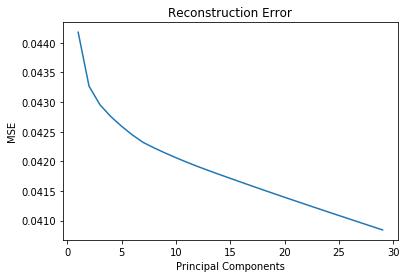

In [19]:
plt.plot(k_range, ae_loss)
plt.xlabel("Principal Components")
plt.ylabel("MSE")
plt.title("Reconstruction Error")

Text(0.5,1,'Norm of Singular Values')

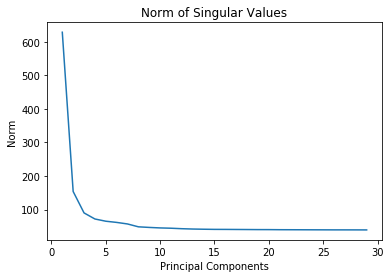

In [22]:
plt.plot(k_range, S[:len(k_range)])
plt.xlabel("Principal Components")
plt.ylabel("Norm")
plt.title("Norm of Singular Values")

Text(0.5,1,'Self-Supervised Loss')

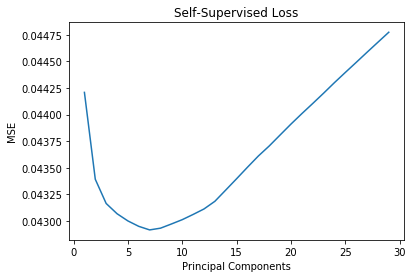

In [21]:
plt.plot(k_range, ss_loss)
plt.xlabel("Principal Components")
plt.ylabel("MSE")
plt.title("Self-Supervised Loss")

In [ ]:
sc.pp.normalize_per_cell(denoised_adata)
sc.pp.sqrt(denoised_adata)
sc.pl.scatter(denoised_adata, x='Mpo', y='Klf1', color='Ifitm1', cmap = 'magma')

In [31]:
import magic
def compute_diff_op(x, lazy_p = 0):
    median_counts = np.median(x.sum(axis=1)) / 2

    X = np.sqrt(normalize_rows(x, median_counts))

    magic_op = magic.MAGIC()
    magic_op.fit(X)

    diff_op = np.array(magic_op.diff_op.todense())

    diff_op = (1 - lazy_p) * diff_op + lazy_p * np.eye(diff_op.shape[0])
    return diff_op

In [58]:
diff_op = compute_diff_op(x1, lazy_p = 0)

Running MAGIC on 2417 cells and 10783 genes.
Calculating graph and diffusion operator...
  Calculating PCA...


/Users/josh/.local/lib/python3.6/site-packages/magic/magic.py:376: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn("Input matrix contains unexpressed genes. "


  Calculated PCA in 4.34 seconds.
  Calculating KNN search...
  Calculated KNN search in 1.02 seconds.
  Calculating affinities...
  Calculated affinities in 2.46 seconds.
Calculated graph and diffusion operator in 7.98 seconds.


In [85]:
paul.obs['diff'] = np.sqrt(diff_op[1,:])

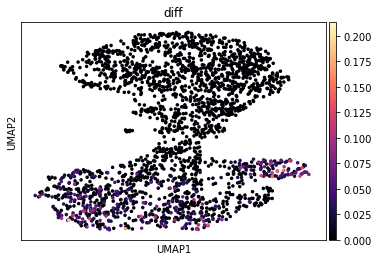

In [86]:
sc.plotting.umap(paul[paul.obs['louvain'] != '10',:], color = ['diff'], cmap = 'magma')

In [ ]:
lazy_diff_op = compute_diff_op(x1, lazy_p = 0.75)

In [95]:
lazy_diff_op.dot(lazy_diff_op[9,:]).sum()

0.9625061076230045

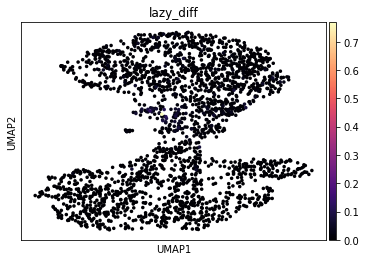

In [90]:
paul.obs['lazy_diff'] = np.sqrt(lazy_diff_op.dot(lazy_diff_op[9,:]))
sc.plotting.umap(paul[paul.obs['louvain'] != '10',:], color = ['lazy_diff'], cmap = 'magma')

Text(0.5,0,'Diffusion Time')

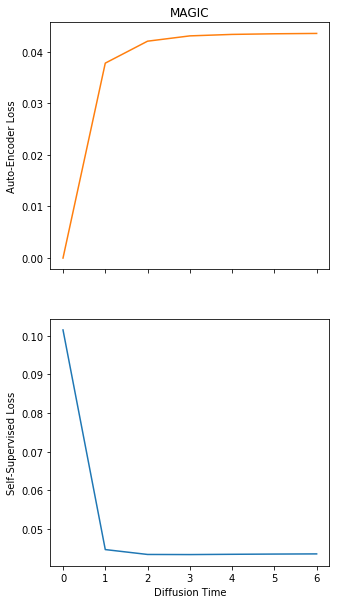

In [34]:
denoised = np.sqrt(x1)
ss_loss, gt_loss, ae_loss = [], [], []
max_t = 7

t_range = np.arange(max_t)

for t in t_range:
    ss_loss.append(mse(denoised, np.sqrt(x2)))
    ae_loss.append(mse(denoised, np.sqrt(x1)))

    denoised = diff_op.dot(denoised)

f, (ax0, ax1) = plt.subplots(2, 1, sharex=True, figsize=(5, 10))

ax0.plot(t_range, ae_loss, color = 'C1')
ax0.set_title("MAGIC")
ax0.set_ylabel('Auto-Encoder Loss')

ax1.plot(t_range, ss_loss)
ax1.set_ylabel('Self-Supervised Loss')
ax1.set_xlabel('Diffusion Time')

In [ ]:
data = paul.copy()
data.X = 
plt.figure(figsize=(6,6))

plt.scatter(data[:,'GATA1'].X + j1, data[:,'KLF1'].X + j2, 
            c = data[:,'PUS1'].X ,cmap='inferno', s=1)

plt.xlabel('GATA1')
plt.ylabel('KLF1')
# plt.yticks([])
# plt.xticks([])

# Hide the right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['bottom'].set_visible(False)
# plt.gca().spines['left'].set_visible(False)

plt.tight_layout()

# plt.savefig(dir + 'raw_data_noaxis.png')
sc.pl.scatter(denoised_adata, x='Mpo', y='Klf1', color='Ifitm1', cmap = 'magma')